# Kernel methods for regression

Still in beta version...

Kernel-based regression combine linear regression techniques with the kernel trick.
They learn a function in the space induced by the respective kernel and the data.
For non-linear kernels, this corresponds to a non-linear function in the original space.

In this notebook, we will explore the capabilities of three of them: Suppert Vector Regression (SVR), Kernel Ridge Regression (KRR) and Gaussian Processes (GP).

This notebook has been re-used from the one created at:

Course: Machine Learning II, Data Science Master (Universidad de Cantabria - UIMP).  
Lecturer: Steven Van Vaerenbergh.

In [1]:
# arrays
import numpy as np
import pandas as pd
import xarray as xr

# plotting
import matplotlib.pyplot as plt

# inline plots
%matplotlib inline

# this is to allow plots to be centered
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

## Part 1. Kernel expansion and basis functions: Intuition

A linear regressor fits the following model to the observed data:

$$f(x) = w^\top x$$

This is the underlying function that is assumed to have generated the data, and the true data typically contains additive noise, $w^\top x + \epsilon$.

### Kernel-based function

The data model adopted by kernel-based regression techniques assumes the data fits a linear model in the feature space. By exploiting the representer theorem kernel trick, this model can be cast back into the input space as the following "kernel expansion":

$$f(x) = \sum_{i=1}^n \alpha_i \kappa(x, x_i)$$

Here, $\kappa(\cdot,\cdot)$ is the "kernel function", $\{x_i\}$, for $i=1,2,\dots,n$, represent the data that were used for training the model, and the coefficients $\alpha_i$ are called "expansion coefficients".

First, we will explore the type of functions that can be modeled in this way
We will start with the Gaussian (or "[RBF](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.rbf_kernel.html)") kernel:

$$\kappa(x, x_i) = \exp\left(-\gamma \Vert x - x_i \Vert^2\right)$$

The parameter $\gamma$ indicates the "spikiness" of the kernel and hence allows to control the smoothness of the resulting function.

Let us plot a single basis function $\kappa(x, x_i)$ with $x_i$ fixed at the origin:

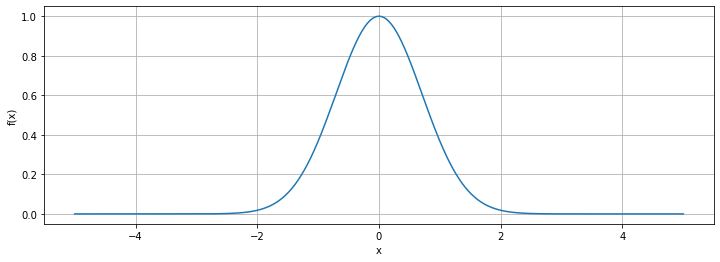

In [2]:
from sklearn.metrics.pairwise import rbf_kernel

# complete the code: x is a vector (numpy.ndarray) of size 1000x1 that contains points between -5 and 5
x = np.linspace(-5,5,1000).reshape((-1,1))
x_i = np.array(0).reshape(-1,1)
gamma = 1

# complete the code: RBF kernel between all elements of x and the element x_i, using parameter gamma
K = rbf_kernel(X=x, Y=x_i, gamma=gamma)

plt.figure(figsize=(12,4))
plt.plot(x,K)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.grid(True)
plt.show()

We now choose a different $x_i$, for instance located at $x=2$ and plot the corresponding basis function:

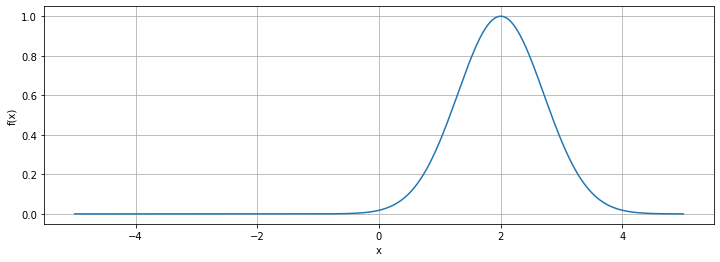

In [3]:
# complete the code: x_i is a 1D array that only contains the element 2
x_i = np.array(2).reshape((-1,1))

K = rbf_kernel(x,x_i,gamma=gamma)

plt.figure(figsize=(12,4))
plt.plot(x,K)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.grid(True)
plt.show()

### Kernel expansion

The complete kernel expansion $f(x) = \sum_{i=1}^n \alpha_i \kappa(x, x_i)$ is obtained by weighing the individual basis functions with coefficients $\alpha_i$ and summing the result.
A kernel expansion with 4 "bases" $x_i$ is constructed as follows:

Dimensions of K: (1000, 4)
Dimensions of alpha_i: (4, 1)


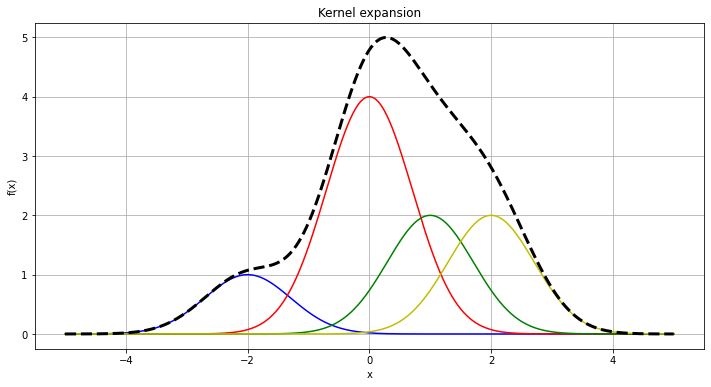

In [4]:
x_i = np.array([-2, 0, 1, 2]).reshape(-1,1) # bases
alpha_i = np.array([1, 4, 2, 2]).reshape(-1,1) # coefficients

K = rbf_kernel(x,x_i,gamma=gamma)

print('Dimensions of K: ' + str(K.shape))
print('Dimensions of alpha_i: ' + str(alpha_i.shape))

# complete the code: scalar product between matrix K and vector alpha_i
f = np.dot(K,alpha_i)

plt.figure(figsize=(12,6))
plt.plot(x,alpha_i[0]*K[:,0],color='b')
plt.plot(x,alpha_i[1]*K[:,1],color='r')
plt.plot(x,alpha_i[2]*K[:,2],color='g')
plt.plot(x,alpha_i[3]*K[:,3],color='y')
plt.plot(x,f,color='k',linestyle='--',linewidth=3)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.grid(True)
plt.title('Kernel expansion')
plt.show()

By modifying the `gamma` parameter we obtain functions with different smoothness.

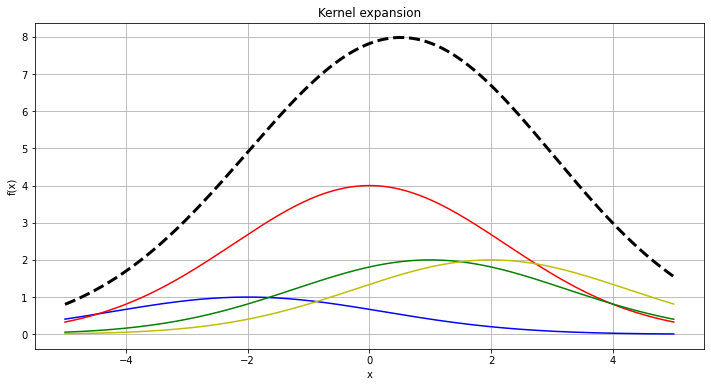

In [5]:
# complete the code: try different values for gamma
gamma = 0.1

K = rbf_kernel(x,x_i,gamma=gamma)

f = np.dot(K,alpha_i)

plt.figure(figsize=(12,6))
plt.plot(x,alpha_i[0]*K[:,0],color='b')
plt.plot(x,alpha_i[1]*K[:,1],color='r')
plt.plot(x,alpha_i[2]*K[:,2],color='g')
plt.plot(x,alpha_i[3]*K[:,3],color='y')
plt.plot(x,f,color='k',linestyle='--',linewidth=3)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.grid(True)
plt.title('Kernel expansion')
plt.show()

### Different kernels

In practice, kernel functions reperesent dissimilarity measures.
Apart from the standard RBF kernel many more kernels are used, such as the polynomial kernel, linear kernel, etc.
An overview of the kernels included in the `metrics` section of scikit learn can be found at https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics.pairwise.

The Gaussian process module of scikit learn includes some advanced kernels, such as the [rational quadratic kernel](http://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.RationalQuadratic.html), the ["white noise" kernel](http://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.WhiteKernel.html), etc.

An overview can be found at https://scikit-learn.org/stable/modules/gaussian_process.html#gp-kernels.

In the following code block we visualize one basis function of [the periodic "ExpSineSquared" kernel](http://scikit-learn.org/stable/modules/generated/sklearn.gaussian_process.kernels.ExpSineSquared.html), which is defined as

$$\kappa(x, x_i) = \exp\left(-2 \left(\frac{\sin\left(\frac{\pi}{p} d(x, x_i)\right)}{l}\right) ^ 2\right)$$

where $l$ is the length scale ($l=1/\gamma$), $p$ is a periodicity parameter, and $d(\cdot,\cdot)$ is a distance measure (the Euclidean distance by default).

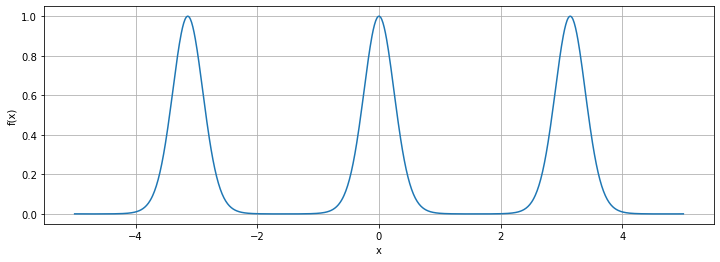

In [6]:
# complete the code: import the ExpSineSquared function
from sklearn.gaussian_process.kernels import ExpSineSquared 

x_i = np.array(0).reshape(-1,1)
x = np.linspace(-5,5,1000).reshape(-1,1)

length_scale = .5
periodicity = np.pi

# calculate the kernels between x and x_i using the syntax of the gaussian_process module
kernel = ExpSineSquared(length_scale=length_scale,periodicity=periodicity )
K = kernel.__call__(x,x_i)

plt.figure(figsize=(12,4))
plt.plot(x,K)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.grid(True)
plt.show()

### Combinations of kernels

Kernel functions can be combined in several ways to produce more complex basis functions.
For instance, the summation or multiplication of two kernel functions produces a new kernel function.

## Part 2. Nonlinear regression with SVR and KRR

Kernel methods for regression apply linear regression techniques in the feature space.

We will now perform nonlinear regression using the [SVR](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html) and [KRR](http://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html) algorithms.
As we've seen, these algorithms aim to find suitable coefficients $\alpha_i$ for the model $f(x) = \sum_{i=1}^n \alpha_i \kappa(x, x_i)$ by minimizing the prediction error according to a given criterion (L2-norm, L1-norm, $\epsilon$-insensitive,...).

In [7]:
# append sscode to path
import os, sys
sys.path.insert(0, os.path.join(os.path.abspath(''), '..'))

# custom
from sscode.data import Loader, load_moana_hindcast_ss

In [8]:
data = Loader(data_to_load=['cfsr','moana','uhslc'], plot=False)


 loading the sea-level-pressure fields... 


 loading daily resampled data... 


 loading the Moana v2 hindcast data... 


 loading and plotting the UHSLC tidal guages... 



In [9]:
# X features as predictor
X = xr.open_dataset('../data/cfsr/cfsr_regional_daily_pcs.nc').PCs[:,:10]

In [10]:
# y variable to predict
y = data.predictand.isel(site=100).ss.load()\
    .resample(time='1D').max().dropna(dim='time')

In [11]:
from sklearn.model_selection import train_test_split

# check common times and reconstruct
common_times = np.intersect1d(
    pd.to_datetime(X.time.values).round('D'),
    pd.to_datetime(y.time.values).round('D')
)
X_train, X_test, y_train, y_test, t_train, t_test = \
train_test_split(
    X.sel(time=common_times), y.sel(time=common_times), 
    common_times, train_size=0.7, shuffle=True
)

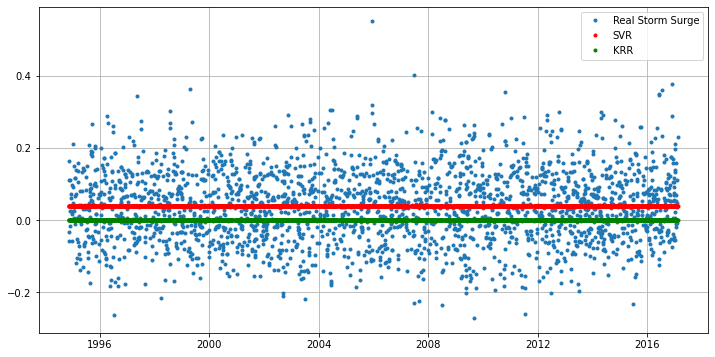

In [12]:
# import the SVR and KernelRidge functions
from sklearn.svm import SVR
from sklearn.kernel_ridge import KernelRidge

# train the SVR. gamma ~ 1/lengthscale
clf_svr = SVR(kernel='rbf', gamma=1/10, C=0.1)
clf_svr.fit(X_train, y_train)

# train the KRR
clf_krr = KernelRidge(kernel='rbf', alpha=5, gamma=1)
clf_krr.fit(X_train, y_train)

# Test the regressors
y_pred_svr = clf_svr.predict(X_test)
y_pred_krr = clf_krr.predict(X_test)

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(t_test,y_test,'.',label='Real Storm Surge')
ax.plot(t_test,y_pred_svr,'.',color='r',label='SVR')
ax.plot(t_test,y_pred_krr,'.',color='g',label='KRR')
ax.plot
ax.grid(True)
ax.legend()
plt.show()

Let us have a look at the support vectors found and their coefficients:

In [13]:
print("Indices of support vectors:")
print(clf_svr.support_,len(clf_svr.support_))

Indices of support vectors:
[   2    4    9 ... 5671 5672 5675] 1775


In [14]:
print("Coefficients:")
print(clf_svr.dual_coef_)

Coefficients:
[[ 0.04050001  0.031625    0.07675    ... -0.006       0.1
   0.08837502]]


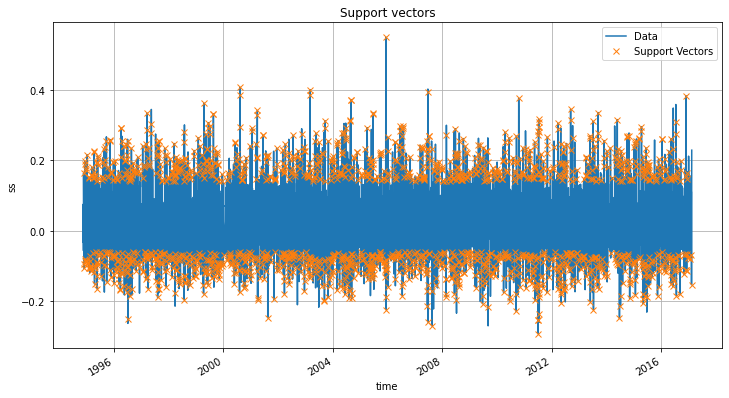

In [15]:
# plot of the support vectors

plt.figure(figsize=(12,6))
y.plot(label='Data')
plt.plot(t_train[clf_svr.support_],y_train[clf_svr.support_],'.',marker='x',label='Support Vectors')
plt.title('Support vectors')
plt.grid(True)
plt.legend()
plt.show()

## Parameter optimization by Grid Search and Cross-validation

Instead of fixing the parameters, we can apply the [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) function to perform a grid search of candidate parameters and select the best set using cross-validation.

Fitting 5 folds for each of 60 candidates, totalling 300 fits
Fitting 2 folds for each of 15 candidates, totalling 30 fits


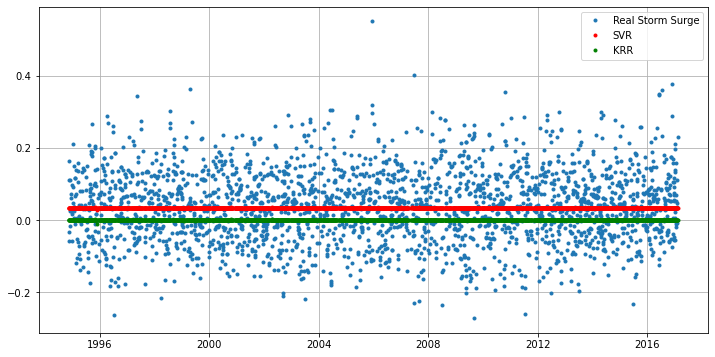

In [16]:
from sklearn.model_selection import GridSearchCV

clf_svr = GridSearchCV(SVR(kernel='rbf', gamma=0.5), cv=5,
                   param_grid={"C": [1e-1, 1e0, 1e1, 1e2],
                               "epsilon": [0.05, 0.1, 0.5],
                               "gamma": np.logspace(-2, 2, 5)},
                      n_jobs=-1,verbose=4)

clf_krr = GridSearchCV(KernelRidge(kernel='rbf', gamma=0.5), cv=2,
                  param_grid={"alpha": [1e1, 0.1, 1e-3],
                              "gamma": np.logspace(-2, 2, 5)},
                      n_jobs=-1,verbose=5)

# train classifiers
clf_svr.fit(X_train, y_train)
clf_krr.fit(X_train, y_train)

# Test the regressors
y_pred_svr = clf_svr.predict(X_test)
y_pred_krr = clf_krr.predict(X_test)

fig, ax = plt.subplots(figsize=(12,6))
ax.plot(t_test,y_test,'.',label='Real Storm Surge')
ax.plot(t_test,y_pred_svr,'.',color='r',label='SVR')
ax.plot(t_test,y_pred_krr,'.',color='g',label='KRR')
ax.plot
ax.grid(True)
ax.legend()
plt.show()

Vemos que en los extremos es mejor el KRR porque utiliza todos sus puntos para realizar el ajuste, mientras que el SVR utiliza solo los puntos de soporte. 

In [17]:
print('Best parameters for SVR: '+ str(clf_svr.best_params_))
print('Best parameters for KRR: '+ str(clf_krr.best_params_))

Best parameters for SVR: {'C': 0.1, 'epsilon': 0.05, 'gamma': 0.01}
Best parameters for KRR: {'alpha': 0.001, 'gamma': 0.01}


In [18]:
print(clf_svr.best_estimator_)

SVR(C=0.1, epsilon=0.05, gamma=0.01)


## Part 3. Gaussian Process Regression

Gaussian Process Regression (GPR) is a Bayesian kernel-based technique that allows to perform nonlinear regression and thus to characterize nonlinear relationships between variables.
When producing predictions for a new input, GPR outputs the complete probability distribution of the estimated output, which is a Gaussian centered around the "prediction mean".
Interestingly, the prediction mean of KRR and GPR are identical. The "prediction variance" calculated by GPR yields an uncertainty interval for each prediction.

A Gaussian process is an immediate generalization of the multivariate normal to infinite dimensions.
It is defined as an infinite collection of random variables, with any marginal subset having a Gaussian distribution.
Thus, the marginalization property is explicit in its definition.
Another way of thinking about an infinite vector is as a function. When we write a function that takes continuous values as inputs, we are essentially implying an infinite vector that only returns values (indexed by the inputs) when the function is called upon to do so.
By the same token, this notion of an infinite-dimensional Gaussian represented as a function allows us to work with them computationally: we are never required to store all the elements of the Gaussian process, only to calculate them on demand.

Gaussian processes are Bayesian techniques: After specifying a model for the data, a prior on the functional form is chosen. Then, the data is observed.
Finally, the posterior distribution of the function to estimate is calculated using Bayes' rule.

### Selecting a prior

The prior of a Gaussian process is encoded in the kernel function, which represents the covariance between any two output points. Below we select a Gaussian (RBF) prior with length scale 1, and we draw several functions that correspond to this covariance.

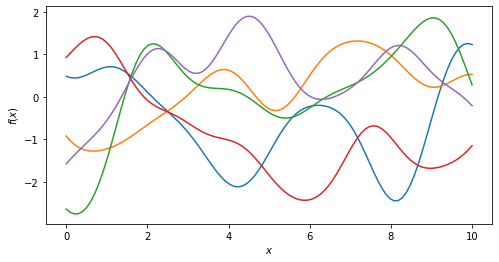

In [19]:
from sklearn.gaussian_process.kernels import RBF

# draw samples from the unconstrained covariance
np.random.seed(1)
x = np.linspace(0, 10, 100)

mu = np.zeros(len(x))

length_scale = 1
kernel = RBF(length_scale)
K = kernel.__call__(x.reshape(-1,1),x.reshape(-1,1))

#Generar funciones de tal forma que su promedio total es 0.
draws = np.random.multivariate_normal(mu, K, 5)

# plot a selection of unconstrained functions
fig = plt.figure(figsize=(8, 4))
plt.plot(x, draws.T, '-')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.show()

## Inference

We fix two data points (x,y) and find the functions that pass through them, given the distribution with mean $\mu$ and covariance $K$. Then, we repeat with 3 data points.

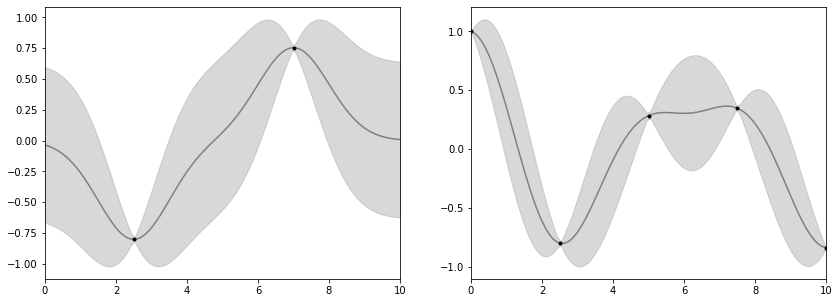

In [20]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel as C


# constrain the mean and covariance with two points
x1 = np.array([2.5, 7])
y1 = np.cos(x1)

# construct the kernel
gp_kernel = C(0.1) * RBF(1)

# fit a GP. (switch off the optimizer option for this example)
gp1 = GaussianProcessRegressor(kernel=gp_kernel,optimizer=None)
gp1.fit(x1[:, None], y1)
f1, sigma1 = gp1.predict(x[:, None], return_std=True)

# plot
fig = plt.figure(figsize=(14, 5))

# plot a constrained function
ax = fig.add_subplot(121)
ax.plot(x, f1, '-', color='gray')
ax.fill_between(x, f1 - 2 * sigma1, f1 + 2 * sigma1, color='gray', alpha=0.3)
ax.plot(x1, y1, '.k', ms=6)

# constrain the mean and covariance with more points
x2 = np.linspace(0,10,5).T
y2 = np.cos(x2)

# fit a GP
gp2 = GaussianProcessRegressor(kernel=gp_kernel,optimizer=None)
gp2.fit(x2[:, None], y2)
f2, sigma2 = gp2.predict(x[:, None], return_std=True)

# plot the second constrained function
ax = fig.add_subplot(122)
ax.plot(x, f2, '-', color='gray')
ax.fill_between(x, f2 - 2 * sigma2, f2 + 2 * sigma2, color='gray', alpha=0.3)
ax.plot(x2, y2, '.k', ms=6)

for ax in fig.axes:
    ax.set_xlim(0, 10)

plt.show()

At this point it is interesting to note that we have not considered any noise in the model.
In the implementation of GPR in scikit-learn, Gaussian noise is added by adding a Gaussian component to the kernel: `kernel = RBF() + WhiteKernel()`.

In the following example we will apply GPR to the noisy sinc data.
We could search for the optimal hyperparameters by running the `GridSearchCV` utility, but GPR includes a more powerful tool.
In particular, the hyperparameters of the kernel are optimized during fitting of `GaussianProcessRegressor` by maximizing the log-marginal-likelihood (LML) based on the passed optimizer.
As the LML may have multiple local optima, the optimizer can be started repeatedly by specifying n_restarts_optimizer.
The first run is always conducted starting from the initial hyperparameter values of the kernel; subsequent runs are conducted from hyperparameter values that have been chosen randomly from the range of allowed values. If the initial hyperparameters should be kept fixed, `None` can be passed as optimizer.

In [27]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel

# Instanciate a Gaussian Process model
gp_kernel = C(1.0, (1e-2, 1e+2)) * RBF(1, (1e-2, 1e2)) + WhiteKernel(1,(1e-4,1e2))
gp = GaussianProcessRegressor(kernel=gp_kernel,
                              n_restarts_optimizer=10,
                              random_state=0)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X_train[::5,:], y_train[::5]) # problem with time convergence

print("GPML kernel: %s" % gp.kernel_)
print("Log-marginal-likelihood: %.3f"
      % gp.log_marginal_likelihood(gp.kernel_.theta))

GPML kernel: 0.1**2 * RBF(length_scale=100) + WhiteKernel(noise_level=0.00334)
Log-marginal-likelihood: 1471.742


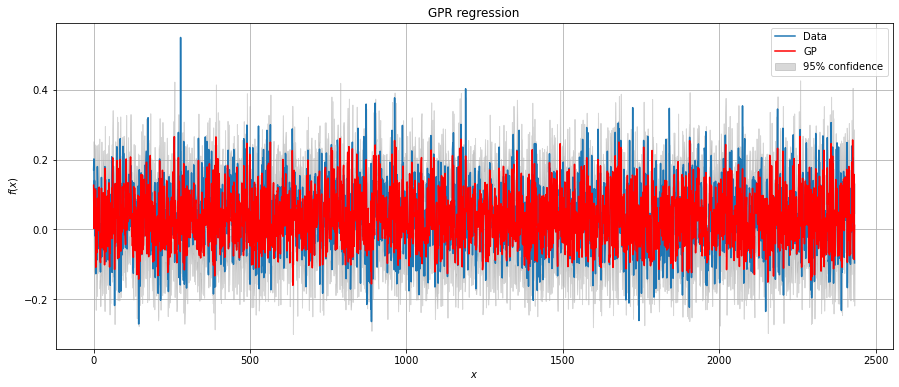

In [28]:
# Make the prediction on the meshed x-axis

y_pred, sigma = gp.predict(X_test, return_std=True)

plt.figure(figsize=(15,6))
plt.plot(y_test,label='Data')
plt.plot(y_pred,color='r',label='GP')
plt.fill_between(np.arange(len(y_pred)), y_pred.ravel() - 2 * sigma, y_pred.ravel() + 2 * sigma,
                 color='gray', alpha=0.3,label='95% confidence')
plt.title('GPR regression')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.grid(True)
plt.legend()


In [29]:
from sscode.validation import generate_stats

In [30]:
generate_stats(y_test.values,y_pred)

('Data comparison is   --   BIAS: -0.01, SI: 0.74, RMSE: 0.37\n and Correlations (Pearson, Rscore): (0.78, 0.61)',
 {'expl_var': 0.6087959669624363,
  'mae': 0.04923028032073405,
  'mse': 0.003946237513793077,
  'me': 0.5010820181807825,
  'medae': 0.040131414067121174,
  'tweedie': 0.003946237513793077,
  'ext_mae': 0.08198733687517679,
  'ext_mse': 0.010208404255094283,
  'ext_rmse': 0.4120635088222767,
  'ext_pearson': 0.3370602546592251,
  'bias': -0.0051134017300375634,
  'si': 0.7421130939890062,
  'rmse': 0.3684325043156921,
  'pearson': 0.7802977298373698,
  'spearman': 0.7797177985279776,
  'rscore': 0.6061866590714547})